# cat_dog 분류 실습

## 데이터셋 압축 풀기

In [3]:
import zipfile
import os
from sklearn.model_selection import train_test_split

In [4]:
zip_file_path = '/content/drive/MyDrive/cat_dog.zip'

# 압축 해제할 폴더 경로
extracted_folder_path = '/content/drive/MyDrive/cat_dog_extracted'

# 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 데이터 생성기 설정
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# 훈련 데이터셋 생성
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/cat_dog_extracted/PetImages',
    target_size=(224, 224),  # 이미지 크기 조절
    batch_size=32,
    class_mode='binary',  # 이진 분류인 경우 'binary'
    subset='training'  # 훈련 데이터 설정
)

# 테스트 데이터셋 생성
test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/cat_dog_extracted/PetImages',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # 검증 데이터 설정
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [25]:
print(len(train_generator))
print(len(test_generator))

625
157


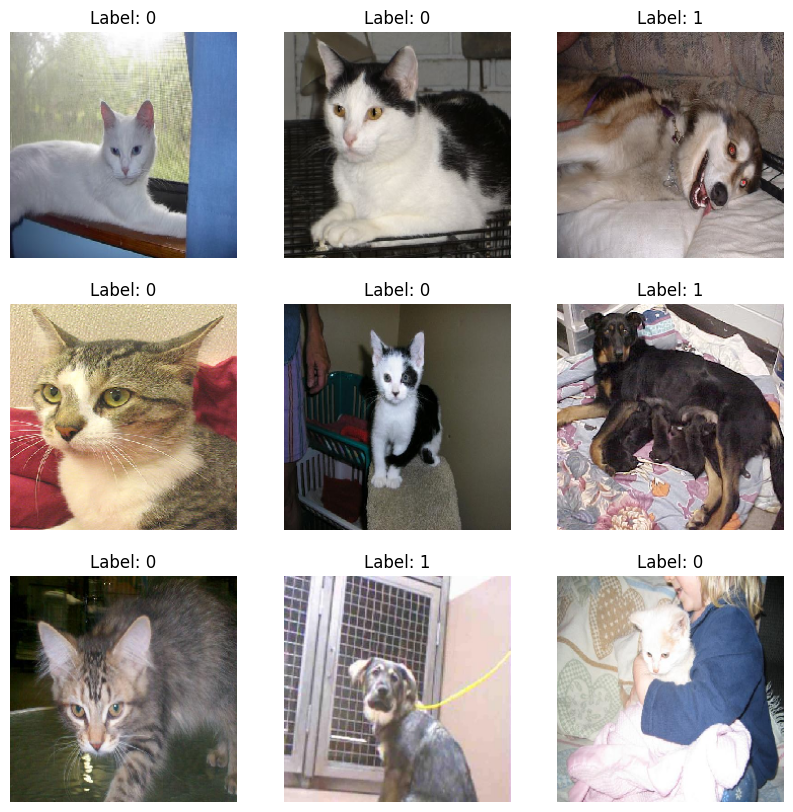

In [26]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)

# 가져온 배치의 첫 번째 이미지와 라벨 시각화
plt.figure(figsize=(10, 10))
for i in range(min(9, len(images))):  # 처음 9장의 이미지만 표시
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")

plt.show()

## CNN 학습

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Sequential 모델 생성
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 2 클래스 이진 분류

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn = model.fit(train_generator, epochs=5, validation_data=test_generator)


Epoch 1/5
625/625 [==============================] - 118s 181ms/step - loss: 0.6825 - accuracy: 0.5890 - val_loss: 0.6058 - val_accuracy: 0.6785
Epoch 2/5
625/625 [==============================] - 97s 155ms/step - loss: 0.5362 - accuracy: 0.7335 - val_loss: 0.5041 - val_accuracy: 0.7505
Epoch 3/5
625/625 [==============================] - 92s 147ms/step - loss: 0.4043 - accuracy: 0.8177 - val_loss: 0.4576 - val_accuracy: 0.7869
Epoch 4/5
625/625 [==============================] - 93s 149ms/step - loss: 0.2578 - accuracy: 0.8918 - val_loss: 0.5003 - val_accuracy: 0.7925
Epoch 5/5
625/625 [==============================] - 106s 169ms/step - loss: 0.0944 - accuracy: 0.9667 - val_loss: 0.7244 - val_accuracy: 0.7807


#

In [32]:
predictions = model.predict(test_generator)

157/157 [==============================] - 20s 129ms/step
[[ 0.21026234]
 [99.99981   ]
 [99.96081   ]
 ...
 [81.77146   ]
 [ 9.726594  ]
 [34.112392  ]]


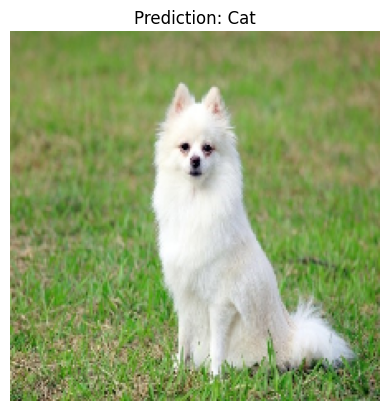

In [39]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
image_path = '/content/강아지1.jpg'

img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

predicted_class = "Dog" if predictions[0][0] > 0.5 else "Cat"

plt.imshow(img)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}')
plt.show()

## VGGNET 전이 학습

In [27]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기 (include_top=False로 설정하여 fully connected layers를 포함하지 않도록 설정)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()

model.add(base_model)

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # 2 클래스(고양이, 개) 이진 분류의 경우

# 기존 모델의 가중치를 동결하여 훈련하지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# 모델 훈련
history_vgg = model.fit(train_generator, epochs=5, validation_data=test_generator)


Epoch 1/5
625/625 [==============================] - 126s 198ms/step - loss: 0.2608 - accuracy: 0.8980 - val_loss: 0.2199 - val_accuracy: 0.9048
Epoch 2/5
625/625 [==============================] - 112s 180ms/step - loss: 0.1315 - accuracy: 0.9469 - val_loss: 0.1993 - val_accuracy: 0.9284
Epoch 3/5
625/625 [==============================] - 115s 184ms/step - loss: 0.1000 - accuracy: 0.9603 - val_loss: 0.1699 - val_accuracy: 0.9358
Epoch 4/5
625/625 [==============================] - 137s 219ms/step - loss: 0.0682 - accuracy: 0.9735 - val_loss: 0.2093 - val_accuracy: 0.9284
Epoch 5/5
625/625 [==============================] - 115s 183ms/step - loss: 0.0539 - accuracy: 0.9796 - val_loss: 0.2253 - val_accuracy: 0.9300


In [45]:
def show_hist(history):

  train_loss = history.history['loss']
  train_accuracy = history.history['accuracy']
  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']

  plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
  plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
  plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()



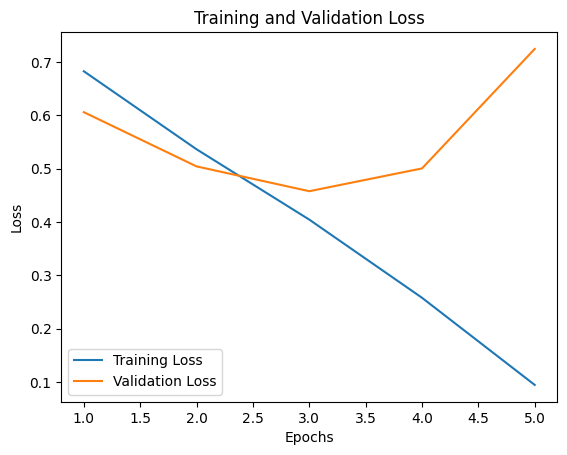

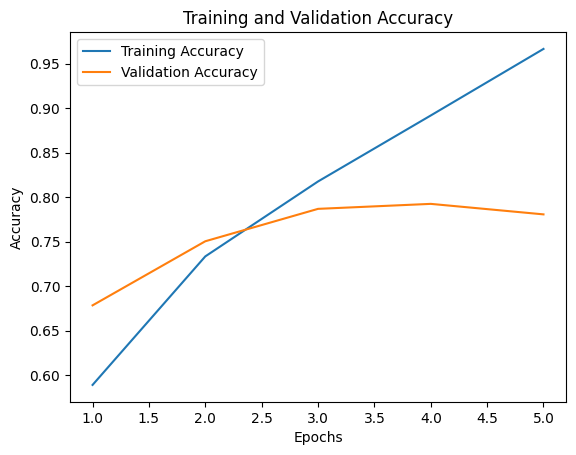

In [46]:
show_hist(history_cnn)

In [ ]:
show_hist(history_vgg)

## 이미지 이상한거 확인

In [19]:
from PIL import Image

dataset_path = '/content/drive/MyDrive/cat_dog_extracted/PetImages'
problematic_images = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        image_path = os.path.join(root, file)
        try:
            img = Image.open(image_path)
        except Exception as e:
            problematic_images.append(image_path)
            print(f"Error opening {image_path}: {e}")

print("Problematic Images:")
for img_path in problematic_images:
    print(img_path)

Error opening /content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/666.jpg: cannot identify image file '/content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/666.jpg'
Error opening /content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/Thumbs.db: cannot identify image file '/content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/Thumbs.db'
Error opening /content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/11702.jpg: cannot identify image file '/content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/11702.jpg'


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Error opening /content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/Thumbs.db: cannot identify image file '/content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/Thumbs.db'
Problematic Images:
/content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/666.jpg
/content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/Thumbs.db
/content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/11702.jpg
/content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/Thumbs.db


In [20]:
import os

# 삭제할 파일 경로들
file_paths_to_delete = [
    '/content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/666.jpg',
    '/content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/11702.jpg'
]

# 파일 삭제
for file_path in file_paths_to_delete:
    try:
        os.remove(file_path)
        print(f"File deleted: {file_path}")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error deleting file {file_path}: {e}")

File deleted: /content/drive/MyDrive/cat_dog_extracted/PetImages/Cat/666.jpg
File deleted: /content/drive/MyDrive/cat_dog_extracted/PetImages/Dog/11702.jpg
